# Import

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import firwin, cheby1, lfilter, freqz, resample, tf2zpk, cheb1ord, cheby1
import soundfile as sf
import pandas as pd

# ANSI S1.11 STANDARD

## Paramètres globaux

In [2]:
fs = 12000 # fréquence d'échantillonnage
bands = np.arange(22, 37)   # bande 22 → 36 (car fu < fs/2)
Nbands = len(bands) # nombre de bandes
iir_order = 4  # ordre des filtres IIR Chebyshev

## Calcul des fréquences ANSI 1/3 octave

In [3]:
def ansi_band(n):
    f0 = 1000 * 2 ** ((n - 30) / 3)
    fl = f0 / 2 ** (1/6)
    fu = f0 * 2 ** (1/6)
    return fl, f0, fu

# stockage des filtres
filters_FIR = []
filters_IIR = []

## Design des filtres FIR et IIR

In [4]:
for n in bands:
    # Pour chaque bande ANSI, on calcule les fréquences de coupure et on normalise (scipy)
    fl, f0, fu = ansi_band(n)
    
    fl_norm = fl / (fs / 2)
    fu_norm = fu / (fs / 2)

    # FIR 1/3 octave (bandpass)
    taps = firwin(                 # design FIR windowed (méthode de Hamming)
        numtaps=128,               # (ordre 127)
        cutoff=[fl, fu],           # bande passante en Hz
        pass_zero=False,
        fs=fs
    )
    filters_FIR.append(taps)

    # IIR Chebyshev type I
    b, a = cheby1(                  # filtre IIR Chebyshev type I d'ordre iir_order
        N=iir_order,
        rp=1,                      # ripple de 1 dB dans la bande passante
        Wn=[fl_norm, fu_norm],     # fréquences normalisées
        btype='bandpass',
        output='ba'                # coefficients b et a directs
    )
    filters_IIR.append((b, a))

print("Les 16 filtres 1/3-octave ont été générés avec succès !")

Les 16 filtres 1/3-octave ont été générés avec succès !


Juste pour rappelle :')
Un SOS d'ordre 2 (ce que l'on a) est de la forme :

$$H_i(z) = 
\frac{
b_{0,i} + b_{1,i} z^{-1} + b_{2,i} z^{-2}
}{
1 + a_{1,i} z^{-1} + a_{2,i} z^{-2}
}
$$

## Plot des réponses fréquentielles (FIR)

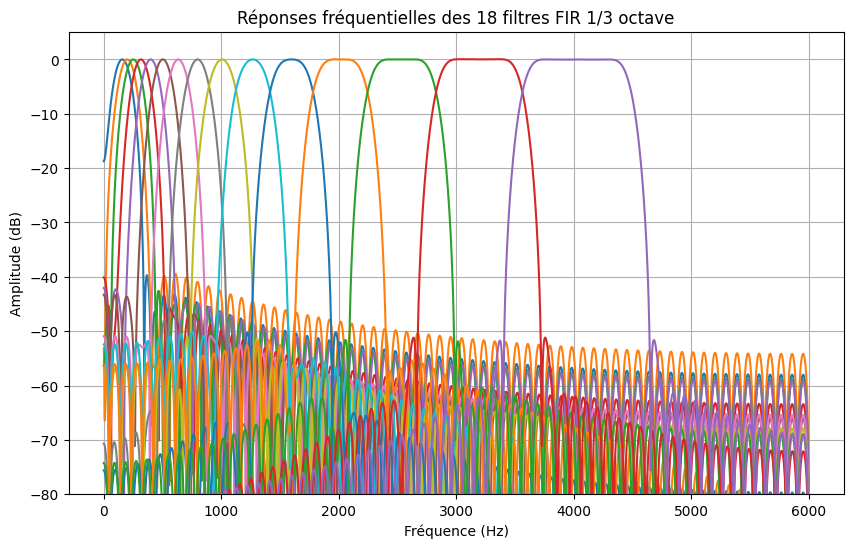

In [5]:
plt.figure(figsize=(10,6))
for taps in filters_FIR:
    # Calcul de la réponse fréquentielle complexe H(e^{jw})
    # w : vecteur de fréquences (en Hz, grâce à fs=fs)
    # h : réponse fréquentielle complexe
    w, h = freqz(taps, [1], worN=2048, fs=fs)
    plt.plot(w, 20*np.log10(np.abs(h)))


plt.title("Réponses fréquentielles des 18 filtres FIR 1/3 octave")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-80, 5])
plt.show()

## Plot des réponses fréquentielles (IIR)

/tmp/ipykernel_87327/3145353853.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20*np.log10(np.abs(h)))


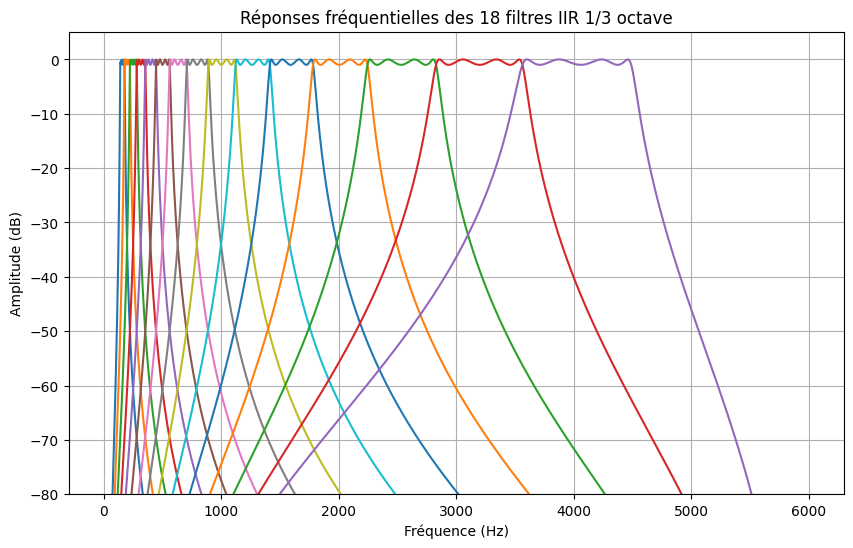

In [6]:
plt.figure(figsize=(10,6))
for b, a in filters_IIR:
    # Calcul de la réponse fréquentielle complexe H(e^{jw})
    # w : vecteur de fréquences (en Hz, grâce à fs=fs)
    # h : réponse fréquentielle complexe
    w, h = freqz(b, a, worN=2048, fs=fs)
    plt.plot(w, 20*np.log10(np.abs(h)))


plt.title("Réponses fréquentielles des 18 filtres IIR 1/3 octave")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-80, 5])
plt.show()

## Test sur audio

In [7]:
signal, fs_in = sf.read("test.wav")

# Convertir en mono si stéréo
if signal.ndim > 1:
    signal = np.mean(signal, axis=1)

# Resample si besoin
if fs_in != fs:
    signal = resample(signal, int(len(signal) * fs / fs_in))
    print(f"Audio resamplé de {fs_in} Hz à {fs} Hz")

filtered_bands = []

#for taps in filters_FIR:
#    filtered_sig = np.convolve(signal, taps, mode='same')

for b, a in filters_IIR:
    filtered_sig = lfilter(b, a, signal)
    filtered_bands.append(filtered_sig)

filtered_bands = np.array(filtered_bands).T

print("Filtrage terminé !")

Audio resamplé de 48000 Hz à 12000 Hz
Filtrage terminé !


## Sauvegarde des bandes filtrées

In [8]:
# Sauvegarde des bandes filtrées
import os
if not os.path.exists('filtered_bands'):
    os.makedirs('filtered_bands')

for i, band in enumerate(bands):
    filename = f"filtered_bands/band_{band}.wav"
    sf.write(filename, filtered_bands[:, i], fs)
    print(f"Bande {band} sauvegardée dans {filename}")

print("Toutes les bandes filtrées ont été sauvegardées !")

Bande 22 sauvegardée dans filtered_bands/band_22.wav
Bande 23 sauvegardée dans filtered_bands/band_23.wav
Bande 24 sauvegardée dans filtered_bands/band_24.wav
Bande 25 sauvegardée dans filtered_bands/band_25.wav
Bande 26 sauvegardée dans filtered_bands/band_26.wav
Bande 27 sauvegardée dans filtered_bands/band_27.wav
Bande 28 sauvegardée dans filtered_bands/band_28.wav
Bande 29 sauvegardée dans filtered_bands/band_29.wav
Bande 30 sauvegardée dans filtered_bands/band_30.wav
Bande 31 sauvegardée dans filtered_bands/band_31.wav
Bande 32 sauvegardée dans filtered_bands/band_32.wav
Bande 33 sauvegardée dans filtered_bands/band_33.wav
Bande 34 sauvegardée dans filtered_bands/band_34.wav
Bande 35 sauvegardée dans filtered_bands/band_35.wav
Bande 36 sauvegardée dans filtered_bands/band_36.wav
Toutes les bandes filtrées ont été sauvegardées !


## Plot de comparaison FIR vs IIR

In [9]:
def add_ansi_overlay(ax, fl, fu, fs):
    """
    Ajoute des superpositions graphiques pour les spécifications ANSI S1.11 sur un axe matplotlib.
    
    Args:
        ax: objet matplotlib.axes.Axes sur lequel ajouter les overlays
        fl: fréquence basse de la bande passante (Hz)
        fu: fréquence haute de la bande passante (Hz)
        fs: fréquence d'échantillonnage (Hz)
    """
    
    # Spécifications ANSI S1.11 classe 2
    ripple_max = 1.0  # ripple max dans la bande passante (dB)
    atten_min = 60.0  # atténuation min dans les bandes d'arrêt (dB)
    
    # Calcul des limites des bandes d'arrêt
    stop_lo_end = fl / (2 ** (1/6))  # fin de la bande d'arrêt basse
    stop_hi_start = fu * (2 ** (1/6))  # début de la bande d'arrêt haute
    
    # Lignes verticales pour les limites de fréquence
    ax.axvline(fl, color='green', linestyle='--', alpha=0.7, label='Début bande passante')
    ax.axvline(fu, color='green', linestyle='--', alpha=0.7, label='Fin bande passante')
    ax.axvline(stop_lo_end, color='red', linestyle='--', alpha=0.7, label='Fin arrêt bas')
    ax.axvline(stop_hi_start, color='red', linestyle='--', alpha=0.7, label='Début arrêt haut')
    
    # Ligne horizontale pour l'atténuation minimale
    ax.axhline(-atten_min, color='red', linestyle='--', alpha=0.7, label='Atténuation min (-60 dB)')
    
    # Zone de ripple dans la bande passante (±1 dB autour de 0 dB)
    ax.fill_between([fl, fu], -ripple_max, ripple_max, color='blue', alpha=0.1, label='Zone ripple (±1 dB)')

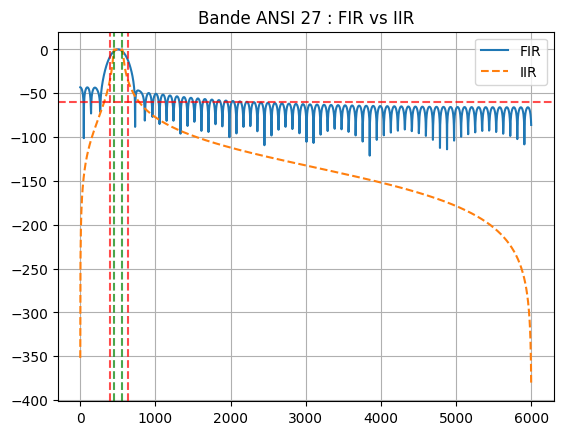

In [10]:
k = 5  # bande 27
fl, f0, fu = ansi_band(bands[k])
taps = filters_FIR[k]
b, a = filters_IIR[k]

# FIR
w, h = freqz(taps, [1], worN=2048, fs=fs)
plt.plot(w, 20*np.log10(np.abs(h)), label="FIR")

# IIR
w2, h2 = freqz(b, a, worN=2048, fs=fs)
plt.plot(w2, 20*np.log10(np.abs(h2)), '--', label="IIR")

plt.legend()
plt.grid(True)
plt.title(f"Bande ANSI {bands[k]} : FIR vs IIR")
add_ansi_overlay(plt.gca(), fl, fu, fs)
plt.show()

In [11]:
def quantize(coeffs, word_length, integer_bits=1, wrap=False):
    """
    Quantifie des coefficients en format virgule fixe Qm.n.
    
    Qm.n = m bits partie entière (avec signe) + n bits fractionnaire.
    Ici : Q(integer_bits).(word_length - integer_bits)
    
    Exemples:
    - quantize(coeffs, 8, 1)  -> Q1.7
    - quantize(coeffs, 16, 3) -> Q3.13
    
    Args:
        coeffs: array des coefficients (float)
        word_length: bits total (inclut bit de signe)
        integer_bits: bits partie entière (1 pour FIR, 3+ pour IIR)
        wrap : False = saturation, True = wrap-around complément a 2
    
    Returns:
        array: coefficients quantifiés (float arrondis)
    """
    
    if word_length <= integer_bits:
        raise ValueError("word_length doit être > integer_bits (inclut bit de signe).")

    # Nombre de bits fractionnaires
    frac_bits = word_length - integer_bits
    
    # Facteur d'échelle pour la partie fractionnaire
    scale = 2**frac_bits
    
    # Passage en entier fixe
    fixed = np.round(coeffs * scale)
    
    # Bornes min/max representables
    MIN = -(2 ** (integer_bits - 1))
    MAX = (2 ** (integer_bits - 1)) - (1 / scale) # ICI - (1 / scale) car c'est la plus petite valeur representable en Qm.n

    
    if wrap:
        # Wrap-around (complement a 2)
        # On ne pense pas que ce soit utile ici, saturation est préférable selon nous
        # En gros quand une valeur dépasse MAX, elle "reboucle" vers MIN et inversement
        
        # Plage totale pour un entier non signé
        range_int = 2 ** word_length
        
        # No joke regardez cette qualité de ligne, on va détailler un peu ;')
        # range_int//2 = 2^(word_length-1) : donc point milieu 
        # fixed.astype(int) convertit en entier pour l'opération modulo
        # Ici modulo est utilisé pour "reboucler" les valeurs hors bornes
        # - (range_int//2) pour soustraire le décalage initial
        fixed = ((fixed.astype(int) + range_int//2) % range_int) - (range_int//2)
    else:
        # Saturation
        # Les valeurs qui dépassent sont "écrasées" aux bornes, donc en théorie moins d'instabilités
        fixed = np.clip(fixed, MIN * scale, MAX * scale)

    return fixed / scale


integer_bits nécessaire pour IIR = 7
WL = 7 bits ignoré (wl <= integer_bits_iir).


/tmp/ipykernel_87327/1693662067.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label='IIR quantifié')
/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:482: RuntimeWarning: invalid value encountered in divide
  h = (npp_polyval(zm1, b, tensor=False) /
/tmp/ipykernel_87327/1693662067.py:38: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), label='FIR quantifié')


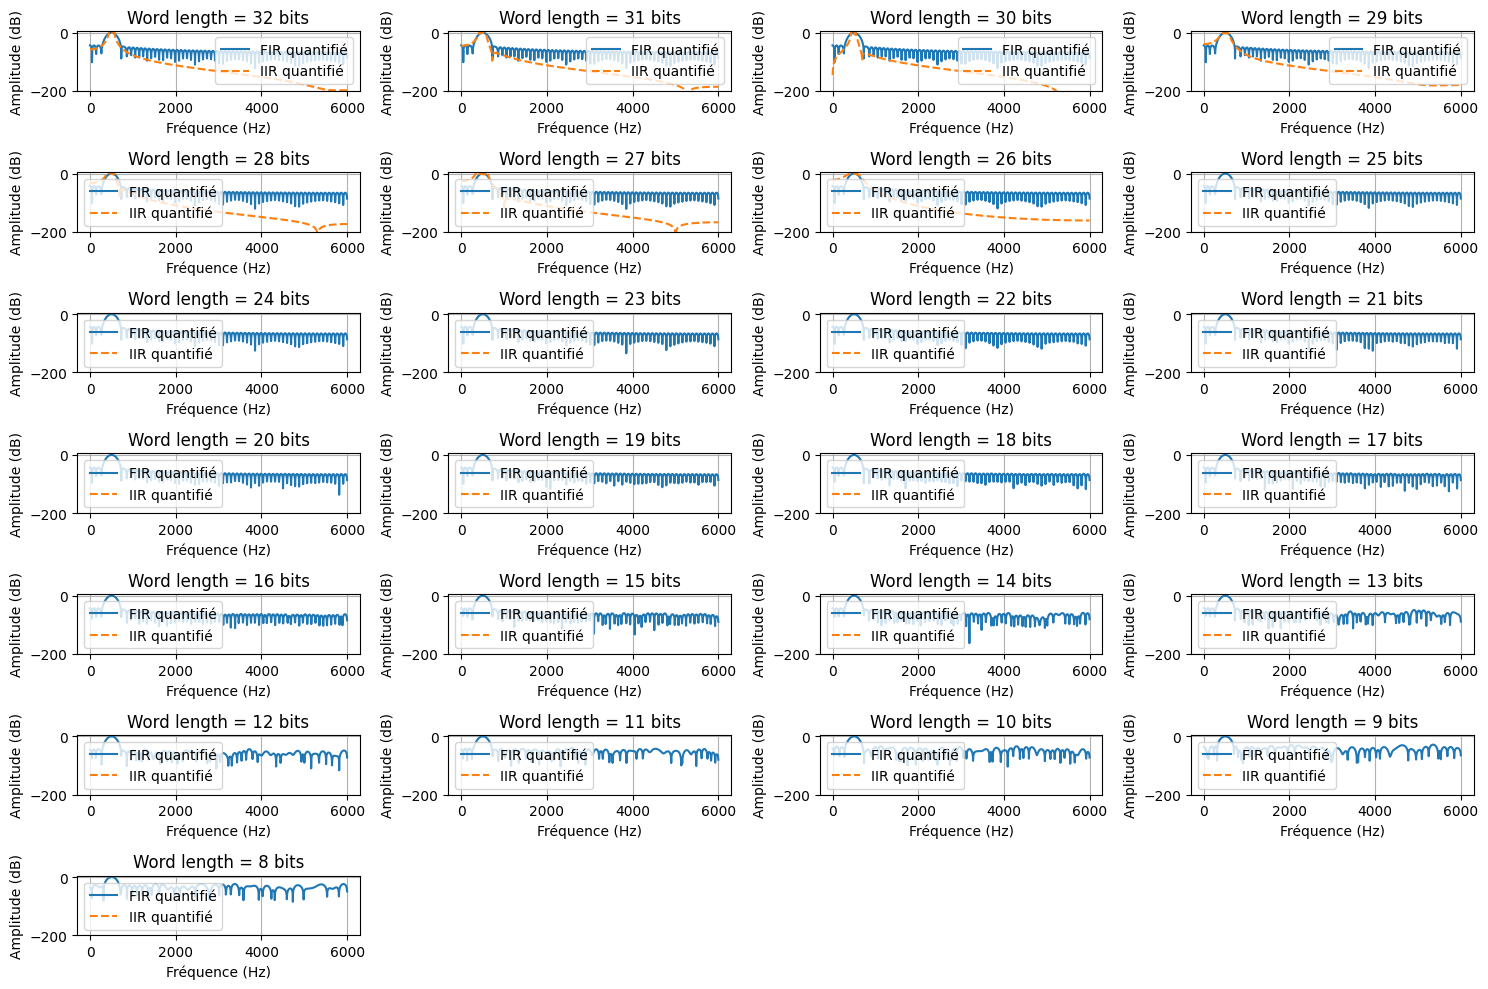

In [12]:
word_lengths = list(range(32, 6, -1))  # 32 à 7 bits

k = 5  # bande 27
taps_original = filters_FIR[k]
b_original, a_original = filters_IIR[k]

# Calcul dynamique pour nombre de bits entiers des coefficients IIR
max_iir_coeff = max(
    np.max(np.abs(b_original)),
    np.max(np.abs(a_original))
)
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print(f"integer_bits nécessaire pour IIR = {integer_bits_iir}")

plt.figure(figsize=(15, 10))

for i, wl in enumerate(word_lengths):

    # Si wl n'a pas assez de bits → on saute
    if wl <= integer_bits_iir:
        print(f"WL = {wl} bits ignoré (wl <= integer_bits_iir).")
        continue

    # FIR quantifié
    taps_q = quantize(taps_original, wl, integer_bits=1)

    # IIR quantifié
    b_q = quantize(b_original, wl, integer_bits=integer_bits_iir)
    a_q = quantize(a_original, wl, integer_bits=integer_bits_iir)
    a_q[0] = 1.0  # normalisation

    # Réponses fréquentielles
    w_fir, h_fir = freqz(taps_q, [1], worN=2048, fs=fs)
    w_iir, h_iir = freqz(b_q, a_q, worN=2048, fs=fs)

    # Plot
    plt.subplot(len(word_lengths)//4 + 1, 4, i+1)
    plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), label='FIR quantifié')
    plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label='IIR quantifié')
    plt.title(f'Word length = {wl} bits')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.grid(True)
    plt.ylim([-200, 5])
    plt.legend()

plt.tight_layout()
plt.show()

Max coeff IIR = 62.799070685974144
integer_bits IIR = 7


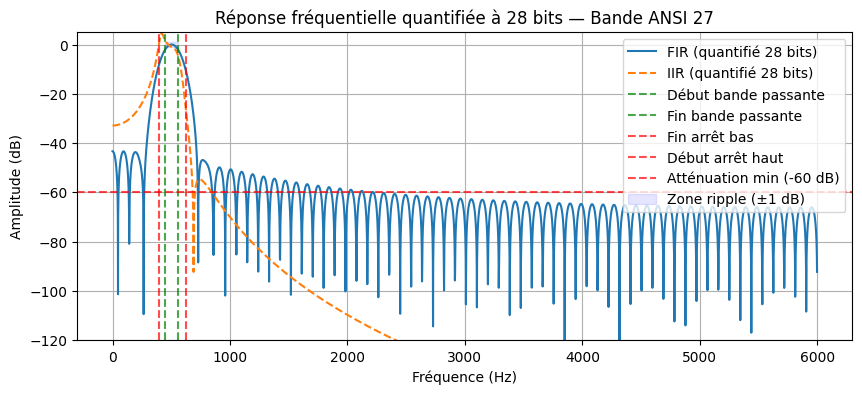

In [13]:
# Choix de la bande
k = 5   # bande ANSI 27 = centre environ 1000 Hz

# Coefficients originaux
taps_original = filters_FIR[k]
b_original, a_original = filters_IIR[k]

# Calcul dynamique pour nombre de bits entiers des coefficients IIR
max_iir_coeff = max(
    np.max(np.abs(b_original)),
    np.max(np.abs(a_original))
)
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print("Max coeff IIR =", max_iir_coeff)
print("integer_bits IIR =", integer_bits_iir)


# Quantification à 28 bits
wl = 28

# FIR quantifié (1 bit entier → Q1.(wl-1))
taps_q = quantize(taps_original, wl, integer_bits=1)

# IIR quantifié :
#  - integer_bits_iir bits pour la partie entière (sûr)
#  - a0 doit rester EXACTEMENT à 1.0
b_q = quantize(b_original, wl, integer_bits=integer_bits_iir)
a_q = quantize(a_original, wl, integer_bits=integer_bits_iir)
a_q[0] = 1.0     # normalisation indispensable

# Réponses fréquentielles
w_fir, h_fir = freqz(taps_q, [1], worN=4096, fs=fs)
w_iir, h_iir = freqz(b_q, a_q, worN=4096, fs=fs)

# AFFICHAGE
plt.figure(figsize=(10, 4))
plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), label=f'FIR (quantifié {wl} bits)')
plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label=f'IIR (quantifié {wl} bits)')

# Specification ANSI (pour la bande 27)
fl, f0, fu = ansi_band(bands[k])
add_ansi_overlay(plt.gca(), fl, fu, fs)

plt.title(f"Réponse fréquentielle quantifiée à {wl} bits — Bande ANSI {bands[k]}")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-120, 5])
plt.legend()
plt.show()


## Comparaison avant/après quantification

/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:1125: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)
/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:1129: RuntimeWarning: invalid value encountered in divide
  b /= b[0]
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


integer_bits pour cette bande IIR = 7
IIR Original – Bande 27:
  Zéros: [-1.00010068+0.00000000e+00j -0.99999999+1.00675237e-04j
 -0.99999999-1.00675237e-04j -0.99989933+0.00000000e+00j
  1.00007597+0.00000000e+00j  0.99999999+7.59558259e-05j
  0.99999999-7.59558259e-05j  0.99992406+0.00000000e+00j]
  Pôles: [0.95282079+0.28772847j 0.95282079-0.28772847j 0.95239068+0.26797693j
 0.95239068-0.26797693j 0.96917678+0.23066192j 0.96917678-0.23066192j
 0.95962177+0.24460122j 0.95962177-0.24460122j]
IIR Quantifié (16 bits) – Bande 27:
  Zéros: []
  Pôles: [1.35422599+0.332761j   1.35422599-0.332761j   0.96378232+0.54944717j
 0.96378232-0.54944717j 1.        +0.j         0.69881089+0.36472125j
 0.69881089-0.36472125j 0.63433036+0.j        ]


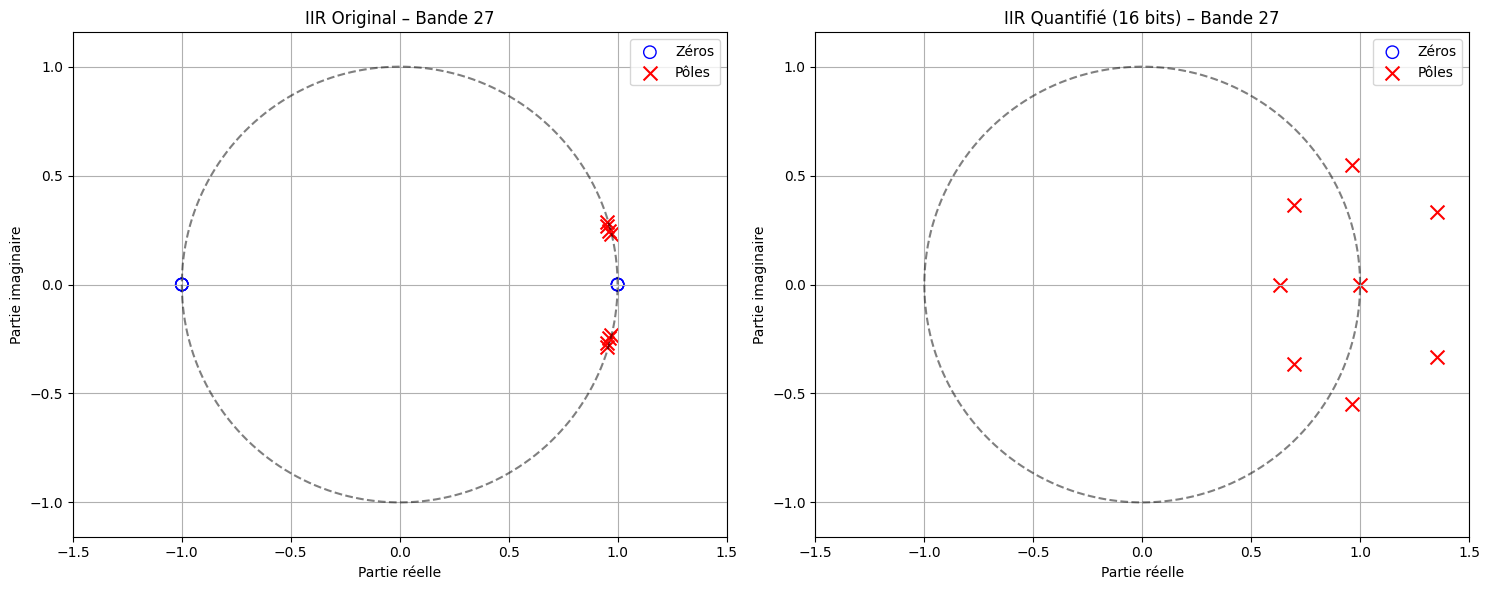

In [14]:
k = 5  # bande 27
b_orig, a_orig = filters_IIR[k]

# Détection automatique des bits entiers IIR
max_iir_coeff = max(
    np.max(np.abs(b_orig)),
    np.max(np.abs(a_orig))
)
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print(f"integer_bits pour cette bande IIR = {integer_bits_iir}")

# Quantification
wl = 16
if wl <= integer_bits_iir:
    raise ValueError(f"WL={wl} bits < integer_bits nécessaires={integer_bits_iir}")

b_q = quantize(b_orig, wl, integer_bits=integer_bits_iir)
a_q = quantize(a_orig, wl, integer_bits=integer_bits_iir)
a_q[0] = 1.0  # normalisation impérative


# Plot pôles / zéros 
def plot_pz(b, a, title, subplot_pos):
    z, p, k = tf2zpk(b, a)

    print(f"{title}:")
    print("  Zéros:", z)
    print("  Pôles:", p)

    plt.subplot(1, 2, subplot_pos)
    plt.scatter(np.real(z), np.imag(z), marker='o', s=80, facecolors='none', edgecolors='b', label='Zéros')
    plt.scatter(np.real(p), np.imag(p), marker='x', s=100, color='r', label='Pôles')

    # Cercle unité
    theta = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5)

    plt.axis('equal')
    plt.grid(True)
    plt.title(title)
    plt.xlabel("Partie réelle")
    plt.ylabel("Partie imaginaire")
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.legend()


plt.figure(figsize=(15, 6))
plot_pz(b_orig, a_orig, f'IIR Original – Bande {bands[k]}', 1)
plot_pz(b_q, a_q, f'IIR Quantifié ({wl} bits) – Bande {bands[k]}', 2)

plt.tight_layout()
plt.show()


integer_bits IIR = 7


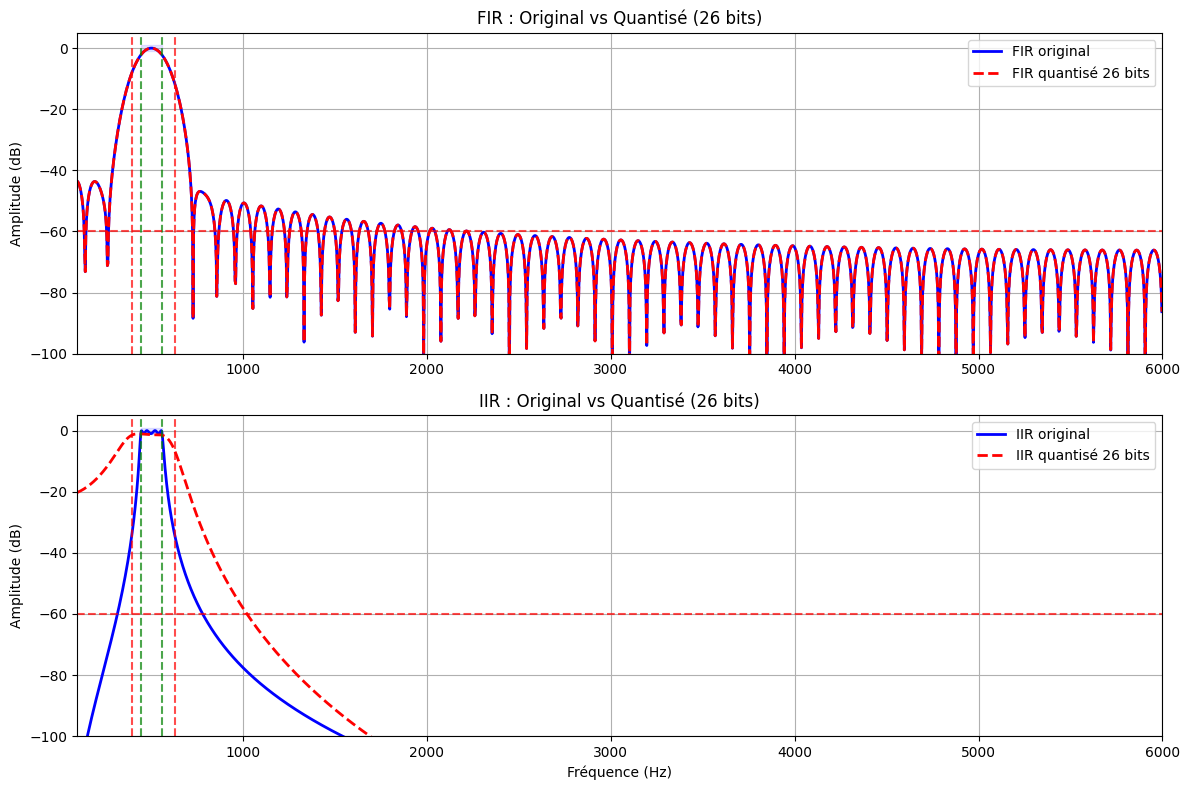

In [15]:
import math

wl = 26
k = 5  # bande 27

taps_orig = filters_FIR[k]
b_orig, a_orig = filters_IIR[k]

# Choix dynamique du nombre de bits entiers pour l’IIR 
max_iir_coeff = max(np.max(np.abs(b_orig)), np.max(np.abs(a_orig)))
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print(f"integer_bits IIR = {integer_bits_iir}")

if wl <= integer_bits_iir:
    raise ValueError(f"WL={wl} est trop petit pour ces IIR (besoin de {integer_bits_iir} bits entiers).")

# Quantifications
taps_q = quantize(taps_orig, wl, integer_bits=1)

b_q = quantize(b_orig, wl, integer_bits=integer_bits_iir)
a_q = quantize(a_orig, wl, integer_bits=integer_bits_iir)
a_q[0] = 1.0

# Réponses fréquentielles
w_orig_fir, h_orig_fir = freqz(taps_orig, [1], worN=2048, fs=fs)
w_q_fir,   h_q_fir   = freqz(taps_q,       [1], worN=2048, fs=fs)

w_orig_iir, h_orig_iir = freqz(b_orig, a_orig, worN=2048, fs=fs)
w_q_iir,   h_q_iir   = freqz(b_q,   a_q,   worN=2048, fs=fs)

# PLOTS 
plt.figure(figsize=(12, 8))

# FIR
plt.subplot(2, 1, 1)
plt.plot(w_orig_fir, 20*np.log10(np.abs(h_orig_fir)), 'b', linewidth=2, label='FIR original')
plt.plot(w_q_fir,   20*np.log10(np.abs(h_q_fir)),   'r--', linewidth=2, label=f'FIR quantisé {wl} bits')
plt.title(f'FIR : Original vs Quantisé ({wl} bits)')
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-100, 5])
plt.legend()
plt.xlim([100, 6000])

# IIR
plt.subplot(2, 1, 2)
plt.plot(w_orig_iir, 20*np.log10(np.abs(h_orig_iir)), 'b', linewidth=2, label='IIR original')
plt.plot(w_q_iir,   20*np.log10(np.abs(h_q_iir)),   'r--', linewidth=2, label=f'IIR quantisé {wl} bits')
plt.title(f'IIR : Original vs Quantisé ({wl} bits)')
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-100, 5])
plt.legend()
plt.xlim([100, 6000])

# Ajout des overlays ANSI
fl, f0, fu = ansi_band(bands[k])
add_ansi_overlay(plt.subplot(2, 1, 1), fl, fu, fs)
add_ansi_overlay(plt.subplot(2, 1, 2), fl, fu, fs)

plt.tight_layout()
plt.show()

In [16]:
print("\n=== Exemple quantif FIR / IIR pour WL = 24 bits ===")
print("Taps FIR orig :", taps_original[:5])
print("Taps FIR q24   :", quantize(taps_original, 24, integer_bits=1)[:5])

print("\nCoeffs IIR orig :")
print("b:", b_original)
print("a:", a_original)

# Choix dynamique du nombre de bits entiers pour l’IIR 
max_iir_coeff = max(np.max(np.abs(b_orig)), np.max(np.abs(a_orig)))
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print(f"integer_bits IIR = {integer_bits_iir}")

b_q24 = quantize(b_original, 24, integer_bits=integer_bits_iir)
a_q24 = quantize(a_original, 24, integer_bits=integer_bits_iir)
a_q24[0] = 1.0

print("\nCoeffs IIR q24 :")
print("b:", b_q24)
print("a:", a_q24)


=== Exemple quantif FIR / IIR pour WL = 24 bits ===
Taps FIR orig : [-0.0006461  -0.00093321 -0.00118781 -0.00139538 -0.00153802]
Taps FIR q24   : [-0.00064611 -0.00093317 -0.0011878  -0.00139534 -0.00153804]

Coeffs IIR orig :
b: [ 2.01533319e-07  0.00000000e+00 -8.06133275e-07  0.00000000e+00
  1.20919991e-06  0.00000000e+00 -8.06133275e-07  0.00000000e+00
  2.01533319e-07]
a: [  1.          -7.66802005  25.99180668 -50.85237574  62.79907069
 -50.12323843  25.2518114   -7.34290969   0.9438761 ]
integer_bits IIR = 7

Coeffs IIR q24 :
b: [ 0.  0. -0.  0.  0.  0. -0.  0.  0.]
a: [  1.          -7.66802216  25.99180603 -50.85237885  62.79907227
 -50.12323761  25.25180817  -7.34291077   0.94387817]


## Interprétation

ICI, chaque ligne du tableau SOS correspond à une section IIR d'ordre 2.  
Le filtre complet est obtenu en mettant toutes ces sections **en cascade**.

Un SOS est toujours de la forme :

[b0  b1  b2   a0  a1  a2] avec **a0 = 1** (normalisation standard).

Les filtres 1/3-octave ANSI S1.11 sont très étroits : leurs pôles sont
proches du cercle unité, donc une très petite erreur sur a1 ou a2 peut
modifier fortement la réponse ou rendre le filtre instable.

À l'inverse, les FIR n'ont **pas de rétroaction**, sont toujours stables et
supportent beaucoup mieux la quantification fixe.

Les filtres Chebyshev type I offrent une transition plus abrupte que les Butterworth
pour le même ordre, au prix d'un ripple dans la bande passante.

## Verification standard + guess ordre du filtre

In [17]:
def verify_ansi_standard(taps, fl, fu, fs, delta_rel=0.05):
    """
    Vérifie si un filtre FIR de bande 1/3-octave respecte le standard
    ANSI S1.11 (classe 2), avec une marge relative
    Args:
    
        taps : array coefficients du filtre FIR
        fl : float fréquence de coupure basse de la bande utile (en Hz)
        fu : float fréquence de coupure haute de la bande utile (en Hz)
        fs : float fréquence d'échantillonnage du système (en Hz)
        delta_rel : float, optionnel marge relative en dB (facteur multiplicatif)

    Returns:
        dict
            {
                "ripple_db"         : ripple dans la bande passante (dB),
                "att_low_db"        : atténuation dans la bande d'arrêt basse (dB),
                "att_high_db"       : atténuation dans la bande d'arrêt haute (dB),
                "valid"             : True si le filtre respecte le standard (avec marge delta),
                "spec_ripple_max"   : limite max du ripple (avec marge),
                "spec_atten_min"    : limite min de l'atténuation (avec marge)
            }
    """
    
    # Spécification AINSI S1.11 classe 2
    ripple_max = 1.0 # + ou - 1 dB
    atten_min  = 60.0 # 60 dB stopband
    
    # On applique la marge relative
    ripple_max *= (1 + delta_rel)
    atten_min  *= (1 - delta_rel)
    

    w, h = freqz(taps, worN=4096, fs=fs)

    # + epsilon pour éviter log(0)
    H = 20 * np.log10(np.abs(h) + 1e-12)

    # Définition des zones de fréquence selon ANSI S1.11:
    # - passband: entre fl et fu
    # - stopband basse: en dessous de fl / 2^(1/6)
    # - stopband haute: au-dessus de fu * 2^(1/6)
    passband = (w >= fl) & (w <= fu)
    stop_lo  = w <  fl / (2 ** (1/6))
    stop_hi  = w >  fu * (2 ** (1/6))

    # En réalité, dans la bande passante le gain du filtre n'est pas parfaitement plat,
    # il y a des variations (ondulations) appelées "ripple"
    # Pour évaluer la performance du filtre, on calcule le ripple comme la
    # différence max-min de l'amplitude en dB dans la passband
    ripple = H[passband].max() - H[passband].min()

    # Atténuation dans les bandes d'arrêt : on prend la valeur la "moins atténuée"
    # (c'est-à-dire la plus proche de 0 dB, donc la pire performance)
    att_lo = -H[stop_lo].max()
    att_hi = -H[stop_hi].max()

    # Vérifications ANSI
    ripple_ok  = ripple <= ripple_max
    stop_lo_ok = att_lo >= atten_min
    stop_hi_ok = att_hi >= atten_min

    return {
        "ripple_db": ripple,
        "att_low_db": att_lo,
        "att_high_db": att_hi,
        "valid": ripple_ok and stop_lo_ok and stop_hi_ok,
        "spec_ripple_max": ripple_max,
        "spec_atten_min": atten_min
    }

In [18]:
def guess_fir_order(fl, fu, fs, delta_rel=0.05, max_order=200000):
    """
    Recherche dichotomique du plus petit ordre FIR qui respecte ANSI S1.11
    
    Note : Scipy n’a pas d’équivalent de 'filterorder' MATLAB pour FIR
    
    Args:
        fl, fu, fs : fréquences et échantillonnage (en Hz)
        delta_rel : marge relative en dB
        max_order : ordre max à tester (évite boucle infinie)
    
    Returns:
        int : ordre minimal FIR, ou None si pas trouvé dans max_order
    """
    
    # Recherche binaire : on teste des ordres de plus en plus petits/grands
    # pour trouver le plus petit ordre qui satisfait les specs ANSI
    low = 1  # ordre min
    high = max_order  # ordre max
    best = None  # meilleur ordre trouvé (initialement None)
    
    while low <= high:
        mid = (low + high) // 2  # ordre milieu à tester
        
        # Crée un filtre FIR d'ordre mid-1 (numtaps = ordre + 1 car normalement numtaps = ordre + 1)
        taps = firwin(
            numtaps=mid,
            cutoff=[fl/(fs/2), fu/(fs/2)],
            pass_zero=False
        )
        
        # Vérifie si ce filtre respecte ANSI avec la marge delta (relative)
        result = verify_ansi_standard(taps, fl, fu, fs, delta_rel)
        
        if result["valid"]:
            # Filtre valide : on peut essayer plus petit (chercher min)
            best = mid
            high = mid - 1
        else:
            # Pas valide : besoin d'ordre plus élevé
            low = mid + 1
    
    return best

In [19]:
def guess_iir_order(fl, fu, fs, delta_rel=0.05):
    """
    Utilise directement cheb1ord pour obtenir l'ordre minimal IIR Chebyshev type I
    
    Args:
        fl, fu, fs : fréquences et échantillonnage (en Hz)
        delta_rel : marge relative en dB
    
    Returns:
        int : ordre minimal IIR Chebyshev type I pour respecter les specs avec marge
    """
    
    # Définition des bandes passante et d'arrêt avec marges relatives pour la stabilité
    # Passband légèrement élargie pour garantir le ripple
    # Stopband légèrement rétrécie pour l'atténuation
    wp = [fl * (1 + delta_rel), fu * (1 - delta_rel)]
    ws = [fl * (1 - delta_rel), fu * (1 + delta_rel)]

    # Normalisation des fréquences car cheb1ord attend aussi des valeurs entre 0 et 1
    wp = np.array(wp) / (fs/2)
    ws = np.array(ws) / (fs/2)

    gpass = 1 * (1 + delta_rel)    # ripple < 1 dB avec marge
    gstop = 60 * (1 - delta_rel)   # atténuation > 60 dB avec marge

    N, Wn = cheb1ord(wp, ws, gpass, gstop)
    return N

In [20]:
fl, f0, fu = ansi_band(27)

fir_order = guess_fir_order(fl, fu, fs, delta_rel=0.05)
iir_order = guess_iir_order(fl, fu, fs, delta_rel=0.05)

print(f"Ordre FIR trouvé : {fir_order}")
print(f"Ordre IIR Chebyshev trouvé : {iir_order}")

Ordre FIR trouvé : 52886
Ordre IIR Chebyshev trouvé : 5


In [21]:
# Tableau des ordres des filtres FIR/IIR pour chaque bande 1/3 octave
# Utilisation des ordres estimés minimal pour respecter ANSI S1.11
data = []
for i, band in enumerate(bands):
    fl, f0, fu = ansi_band(band)
    fir_order_guessed = guess_fir_order(fl, fu, fs, delta_rel=0.05)
    iir_order_guessed = guess_iir_order(fl, fu, fs, delta_rel=0.05)
    data.append([band, fir_order_guessed, iir_order_guessed])

df = pd.DataFrame(data, columns=['Bande ANSI', 'Ordre FIR estimé', 'Ordre IIR estimé'])
df

,Bande ANSI,Ordre FIR estimé,Ordre IIR estimé
0,22,32716,5
1,23,151201,5
2,24,12498,5
3,25,19692,5
4,26,75659,5
5,27,52886,5
6,28,9889,5
7,29,37830,6
8,30,26467,6
9,31,16231,6
